In [1]:
from collections import Counter
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

# import seaborn as sns
# import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
from transformers import RobertaTokenizer, TFRobertaModel

In [3]:
df = pd.read_csv("..//efcamdat_sub.csv")

In [4]:
df['cefr_numeric'].value_counts()

cefr_numeric
3    100000
2    100000
1    100000
4     61329
5     14698
6      1940
Name: count, dtype: int64

In [5]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [6]:
df.columns

Index(['id', 'level', 'unit', 'learner_id', 'learner_nationality', 'grade',
       'date', 'topic_id', 'text', 'cefr_numeric', 'cefr_grouped'],
      dtype='object')

In [7]:
df.shape[0]

377967

In [8]:
df['labels'] = df['cefr_numeric'].apply(lambda x: x-1)

In [9]:
text = df['text']
labels = df['labels']

In [23]:
(train_texts, test_texts, train_labels, test_labels) = train_test_split(text, labels, test_size=.1, shuffle=True)

In [24]:
len(test_texts)

37797

In [25]:
len(train_texts)

340170

In [26]:
# valid_texts_s = train_texts.iloc[:1000]
# valid_labels_s = train_labels.iloc[:1000]
# train_texts_s = train_texts.iloc[1000:20000]
# train_labels_s = train_labels.iloc[1000:20000]
# test_texts_s = test_texts.iloc[:1000]
# test_labels_s = test_labels.iloc[:1000]

valid_texts = train_texts.iloc[:40607].copy()
valid_labels = train_labels.iloc[:40607].copy()
train_texts = train_texts.iloc[40607:]
train_labels = train_labels.iloc[40607:]

In [28]:
train_labels

39899     2
275537    0
139435    1
333147    3
242055    0
         ..
20447     2
82668     2
86991     2
357668    3
264957    0
Name: labels, Length: 299563, dtype: int64

In [29]:
max_length = 85

In [30]:
rtokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [31]:
train_encodings = rtokenizer(list(train_texts), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
valid_encodings = rtokenizer(list(valid_texts), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

In [32]:
def create_roberta_cl_model(model,
                         num_classes = 6,
                         dropout=0.3,
                         learning_rate=0.0001):
    """
    """
    model.trainable = False

    tf.keras.mixed_precision.set_global_policy('mixed_float16')

    input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int64, name='input_ids_layer')
    #token_type_ids = tf.keras.layers.Input(shape=(300,), dtype=tf.int32, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int64, name='attention_mask_layer')

    model_inputs = [input_ids, attention_mask]
    model_out = model(input_ids=input_ids, attention_mask=attention_mask)

    model_out = model_out.last_hidden_state

    conv = tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu')(model_out)
    conv = tf.keras.layers.MaxPooling1D(pool_size=2)(conv)
    conv = tf.keras.layers.Dropout(dropout)(conv)
    lstm = tf.keras.layers.LSTM(units=256, return_sequences=False, return_state=False)(conv)
    lstm = tf.keras.layers.Dropout(dropout)(lstm)

    classification = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_layer')(lstm)

    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=0.1)
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)

    classification_model.compile(optimizer=optimizer,
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                 metrics='accuracy')

    return classification_model

In [33]:
roberta_cl_model = create_roberta_cl_model(model=roberta_model, num_classes=6)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Ti, compute capability 8.6


In [34]:
roberta_cl_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids_layer (InputLayer)   [(None, None)]       0           []                               
                                                                                                  
 attention_mask_layer (InputLay  [(None, None)]      0           []                               
 er)                                                                                              
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_ids_layer[0][0]',        
 el)                            thPoolingAndCrossAt               'attention_mask_layer[0][0]']   
                                tentions(last_hidde                                           

In [35]:
dataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": train_encodings.input_ids, "attention_mask_layer": train_encodings.attention_mask}, train_labels))
dataset = dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

vdataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": valid_encodings.input_ids, "attention_mask_layer": valid_encodings.attention_mask}, valid_labels))
vdataset = vdataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [36]:
import gc
from tensorflow.keras.backend import clear_session

# Clear session and free memory before starting the training
clear_session()
gc.collect()

23297

In [37]:
# test_model_history = test_model2.fit([train_encodings.input_ids, train_encodings.attention_mask],
#                                       train_labels,
#                                       validation_data=([valid_encodings.input_ids, valid_encodings.attention_mask],
#                                       valid_labels),
#                                       batch_size=32,
#                                       epochs=3)

roberta_cl_model_history = roberta_cl_model.fit(dataset,
                                      validation_data=vdataset,
                                      epochs=1)

9362/9362 [==============================] - 1153s 121ms/step - loss: 0.3717 - accuracy: 0.8718 - val_loss: 0.2046 - val_accuracy: 0.9335


In [38]:
test_encodings = rtokenizer(list(test_texts), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

In [39]:
tdataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": test_encodings.input_ids, "attention_mask_layer": test_encodings.attention_mask}, test_labels))
tdataset = tdataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [40]:
roberta_cl_model.evaluate(tdataset)

1182/1182 [==============================] - 111s 94ms/step - loss: 0.2067 - accuracy: 0.9333


[0.2066807746887207, 0.9333280324935913]

In [41]:
preds = roberta_cl_model.predict(tdataset)

1182/1182 [==============================] - 117s 96ms/step


In [42]:
preds = tf.argmax(preds, axis=-1)

In [43]:
print(classification_report(test_labels, preds.numpy()))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      9960
           1       0.93      0.96      0.95     10064
           2       0.93      0.93      0.93     10008
           3       0.91      0.91      0.91      6042
           4       0.90      0.67      0.77      1535
           5       0.47      0.43      0.45       188

    accuracy                           0.93     37797
   macro avg       0.85      0.81      0.83     37797
weighted avg       0.93      0.93      0.93     37797



In [44]:
cm = tf.math.confusion_matrix(test_labels, preds)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

In [45]:
cm

<tf.Tensor: shape=(6, 6), dtype=float64, numpy=
array([[9.73393574e-01, 1.77710843e-02, 4.81927711e-03, 3.31325301e-03,
        7.02811245e-04, 0.00000000e+00],
       [1.73887122e-02, 9.58664547e-01, 1.76868045e-02, 4.67011129e-03,
        9.93640700e-04, 5.96184420e-04],
       [7.09432454e-03, 3.10751399e-02, 9.31454836e-01, 2.76778577e-02,
        2.39808153e-03, 2.99760192e-04],
       [7.77888117e-03, 2.36676597e-02, 4.43561735e-02, 9.10129096e-01,
        9.76497848e-03, 4.30321086e-03],
       [2.67100977e-02, 3.71335505e-02, 1.34201954e-01, 9.25081433e-02,
        6.72964169e-01, 3.64820847e-02],
       [1.06382979e-02, 2.65957447e-02, 1.11702128e-01, 3.24468085e-01,
        1.01063830e-01, 4.25531915e-01]])>

Text(220.72222222222223, 0.5, 'True')

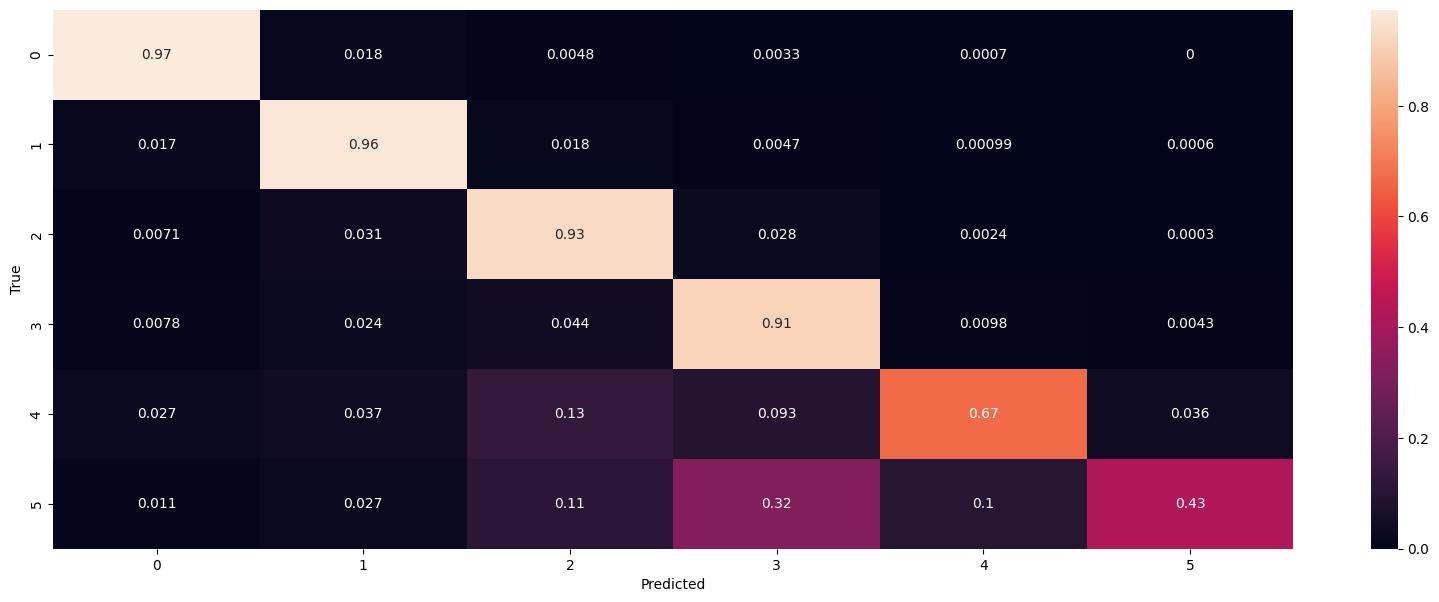

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")

In [47]:
print("The % of A1s is: ", df['cefr_numeric'].value_counts()[1] / len(df))
print("The % of A2s is: ", df['cefr_numeric'].value_counts()[2] / len(df))
print("The % of B1s is: ", df['cefr_numeric'].value_counts()[3] / len(df))
print("The % of B2s is: ", df['cefr_numeric'].value_counts()[4] / len(df))
print("The % of C1s is: ", df['cefr_numeric'].value_counts()[5] / len(df))

The % of A1s is:  0.2645733622247445
The % of A2s is:  0.2645733622247445
The % of B1s is:  0.2645733622247445
The % of B2s is:  0.16226019731881355
The % of C1s is:  0.03888699277979295


## 3->6 Class Model

In [93]:
train_labels_group = train_labels.copy()
train_labels_group[train_labels_group == 1] = 0
train_labels_group[(train_labels_group == 2) | (train_labels_group == 3)] = 1
train_labels_group[(train_labels_group == 4) | (train_labels_group == 5)] = 2

valid_labels_group = valid_labels.copy()
valid_labels_group[valid_labels_group == 1] = 0
valid_labels_group[(valid_labels_group == 2) | (valid_labels_group == 3)] = 1
valid_labels_group[(valid_labels_group == 4) | (valid_labels_group == 5)] = 2

test_labels_group = test_labels.copy()
test_labels_group[test_labels_group == 1] = 0
test_labels_group[(test_labels_group == 2) | (test_labels_group == 3)] = 1
test_labels_group[(test_labels_group == 4) | (test_labels_group == 5)] = 2

In [112]:
roberta_model_grouped = create_roberta_cl_model(model=roberta_model, num_classes=3)

In [113]:
dataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": train_encodings.input_ids, "attention_mask_layer": train_encodings.attention_mask}, train_labels_group))
dataset = dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

vdataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": valid_encodings.input_ids, "attention_mask_layer": valid_encodings.attention_mask}, valid_labels_group))
vdataset = vdataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [114]:
roberta_grouped_history = roberta_model_grouped.fit(dataset,
                                      validation_data=vdataset,
                                      epochs=1)

9362/9362 [==============================] - 1172s 124ms/step - loss: 0.2008 - accuracy: 0.9295 - val_loss: 0.1295 - val_accuracy: 0.9582


In [115]:
tdataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": test_encodings.input_ids, "attention_mask_layer": test_encodings.attention_mask}, test_labels_group))
tdataset = tdataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [116]:
roberta_model_grouped.evaluate(tdataset)

1182/1182 [==============================] - 116s 98ms/step - loss: 0.1286 - accuracy: 0.9592


[0.1286352276802063, 0.959229588508606]

In [117]:
preds = roberta_model_grouped.predict(tdataset)
preds = tf.argmax(preds, axis=-1)

1182/1182 [==============================] - 118s 97ms/step


In [118]:
cm = tf.math.confusion_matrix(test_labels_group, preds)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Text(220.72222222222223, 0.5, 'True')

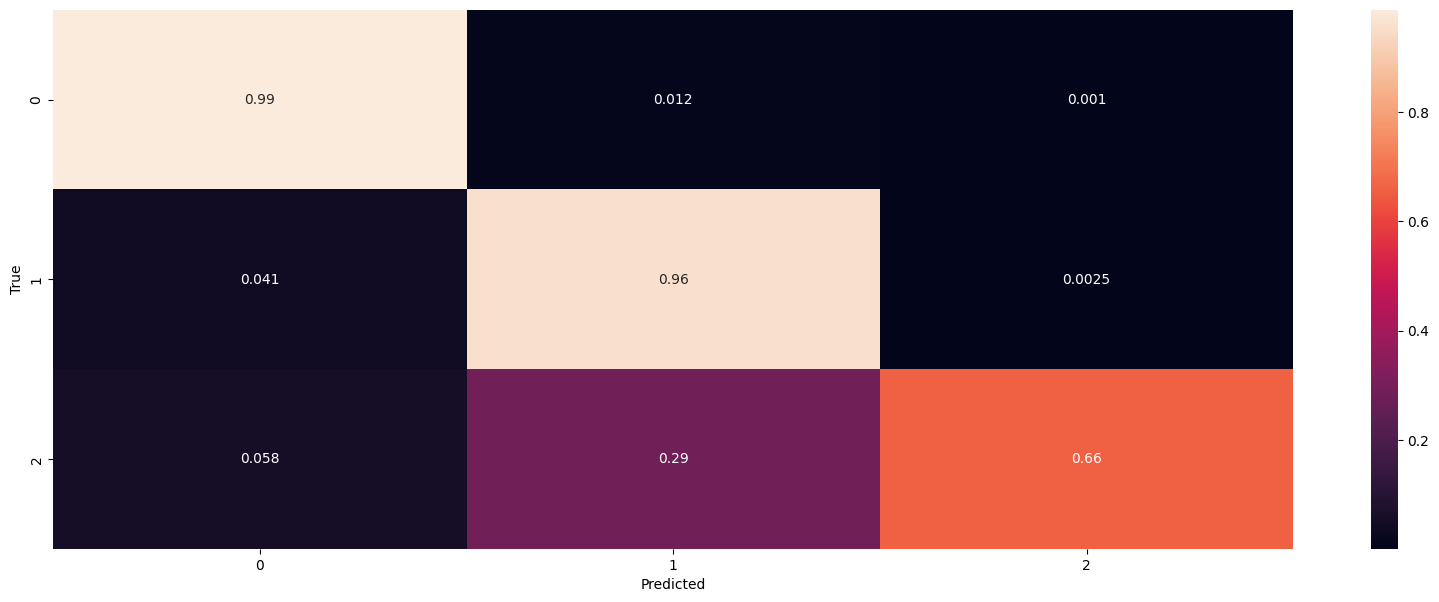

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")

### Discriminate betweeen A1/A2, B1/B2, C1/C2

In [126]:
#A
A_train_mask = tf.equal(train_labels_group, 0)
A_train_encodings = {"input_ids": tf.boolean_mask(train_encodings['input_ids'], A_train_mask),
                     "attention_mask": tf.boolean_mask(train_encodings['attention_mask'], A_train_mask)}
A_train_labels =  tf.boolean_mask(train_labels.copy(), A_train_mask)
A_dataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": A_train_encodings['input_ids'], "attention_mask_layer": A_train_encodings['attention_mask']}, A_train_labels))
A_dataset = A_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

A_valid_mask = tf.equal(valid_labels_group, 0)
A_valid_encodings = {"input_ids": tf.boolean_mask(valid_encodings['input_ids'], A_valid_mask),
                     "attention_mask": tf.boolean_mask(valid_encodings['attention_mask'], A_valid_mask)}
A_valid_labels =  tf.boolean_mask(valid_labels.copy(), A_valid_mask)
A_vdataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": A_valid_encodings['input_ids'], "attention_mask_layer": A_valid_encodings['attention_mask']}, A_valid_labels))
A_vdataset = A_vdataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

A_test_mask = tf.equal(test_labels_group, 0)
A_test_encodings = {"input_ids": tf.boolean_mask(test_encodings['input_ids'], A_test_mask),
                     "attention_mask": tf.boolean_mask(test_encodings['attention_mask'], A_test_mask)}
A_test_labels =  tf.boolean_mask(test_labels.copy(), A_test_mask)
A_tdataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": A_test_encodings['input_ids'], "attention_mask_layer": A_test_encodings['attention_mask']}, A_test_labels))
A_tdataset = A_tdataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [129]:
A_model = create_roberta_cl_model(model=roberta_model, num_classes=2)

In [130]:
A_model_history = A_model.fit(A_dataset,
                            validation_data=A_vdataset,
                            epochs=1)

4953/4953 [==============================] - 597s 118ms/step - loss: 0.1396 - accuracy: 0.9506 - val_loss: 0.0588 - val_accuracy: 0.9794


In [134]:
#B
B_train_mask = tf.equal(train_labels_group, 1)
B_train_encodings = {"input_ids": tf.boolean_mask(train_encodings['input_ids'], B_train_mask),
                     "attention_mask": tf.boolean_mask(train_encodings['attention_mask'], B_train_mask)}
B_train_labels =  tf.boolean_mask(train_labels.copy(), B_train_mask) - 2
B_dataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": B_train_encodings['input_ids'], "attention_mask_layer": B_train_encodings['attention_mask']}, B_train_labels))
B_dataset = B_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

B_valid_mask = tf.equal(valid_labels_group, 1)
B_valid_encodings = {"input_ids": tf.boolean_mask(valid_encodings['input_ids'], B_valid_mask),
                     "attention_mask": tf.boolean_mask(valid_encodings['attention_mask'], B_valid_mask)}
B_valid_labels =  tf.boolean_mask(valid_labels.copy(), B_valid_mask) - 2
B_vdataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": B_valid_encodings['input_ids'], "attention_mask_layer": B_valid_encodings['attention_mask']}, B_valid_labels))
B_vdataset = B_vdataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

B_test_mask = tf.equal(test_labels_group, 1)
B_test_encodings = {"input_ids": tf.boolean_mask(test_encodings['input_ids'], B_test_mask),
                     "attention_mask": tf.boolean_mask(test_encodings['attention_mask'], B_test_mask)}
B_test_labels =  tf.boolean_mask(test_labels.copy(), B_test_mask) - 2
B_tdataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": B_test_encodings['input_ids'], "attention_mask_layer": B_test_encodings['attention_mask']}, B_test_labels))
B_tdataset = B_tdataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [135]:
B_model = create_roberta_cl_model(model=roberta_model, num_classes=2)

In [136]:
B_model_history = B_model.fit(B_dataset,
                              validation_data=B_vdataset,
                              epochs=1)

3999/3999 [==============================] - 511s 125ms/step - loss: 0.2263 - accuracy: 0.9074 - val_loss: 0.1763 - val_accuracy: 0.9356


In [137]:
#C
C_train_mask = tf.equal(train_labels_group, 2)
C_train_encodings = {"input_ids": tf.boolean_mask(train_encodings['input_ids'], C_train_mask),
                     "attention_mask": tf.boolean_mask(train_encodings['attention_mask'], C_train_mask)}
C_train_labels =  tf.boolean_mask(train_labels.copy(), C_train_mask) - 4
C_dataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": C_train_encodings['input_ids'], "attention_mask_layer": C_train_encodings['attention_mask']}, C_train_labels))
C_dataset = C_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

C_valid_mask = tf.equal(valid_labels_group, 2)
C_valid_encodings = {"input_ids": tf.boolean_mask(valid_encodings['input_ids'], C_valid_mask),
                     "attention_mask": tf.boolean_mask(valid_encodings['attention_mask'], C_valid_mask)}
C_valid_labels =  tf.boolean_mask(valid_labels.copy(), C_valid_mask) - 4
C_vdataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": C_valid_encodings['input_ids'], "attention_mask_layer": C_valid_encodings['attention_mask']}, C_valid_labels))
C_vdataset = C_vdataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

C_test_mask = tf.equal(test_labels_group, 2)
C_test_encodings = {"input_ids": tf.boolean_mask(test_encodings['input_ids'], C_test_mask),
                     "attention_mask": tf.boolean_mask(test_encodings['attention_mask'], C_test_mask)}
C_test_labels =  tf.boolean_mask(test_labels.copy(), C_test_mask) - 4
C_tdataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": C_test_encodings['input_ids'], "attention_mask_layer": C_test_encodings['attention_mask']}, C_test_labels))
C_tdataset = C_tdataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [138]:
C_model = create_roberta_cl_model(model=roberta_model, num_classes=2)

In [139]:
C_model_history = C_model.fit(C_dataset,
                              validation_data=C_vdataset,
                              epochs=1)

411/411 [==============================] - 65s 132ms/step - loss: 0.2568 - accuracy: 0.9058 - val_loss: 0.1354 - val_accuracy: 0.9475


### Combine

In [144]:
a_pred_mask = tf.equal(preds, 0)
b_pred_mask = tf.equal(preds, 1)
c_pred_mask = tf.equal(preds, 2)

a_test_encodings = {"input_ids": tf.boolean_mask(test_encodings['input_ids'], a_pred_mask),
                     "attention_mask": tf.boolean_mask(test_encodings['attention_mask'], a_pred_mask)}
a_preds = A_model.predict([a_test_encodings['input_ids'], a_test_encodings["attention_mask"]])
a_preds = tf.argmax(a_preds, axis=-1)
a_preds = a_preds.numpy() 

b_test_encodings = {"input_ids": tf.boolean_mask(test_encodings['input_ids'], b_pred_mask),
                     "attention_mask": tf.boolean_mask(test_encodings['attention_mask'], b_pred_mask)}
b_preds = B_model.predict([b_test_encodings['input_ids'], b_test_encodings["attention_mask"]])
b_preds = tf.argmax(b_preds, axis=-1)
b_preds = b_preds.numpy() + 2

c_test_encodings = {"input_ids": tf.boolean_mask(test_encodings['input_ids'], c_pred_mask),
                     "attention_mask": tf.boolean_mask(test_encodings['attention_mask'], c_pred_mask)}
c_preds = C_model.predict([c_test_encodings['input_ids'], c_test_encodings["attention_mask"]])
c_preds = tf.argmax(c_preds, axis=-1)
c_preds = c_preds.numpy() + 4


predictions_comb = preds.numpy()
predictions_comb[a_pred_mask] = a_preds
predictions_comb[b_pred_mask] = b_preds
predictions_comb[c_pred_mask] = c_preds

38/38 [==============================] - 4s 95ms/step


In [145]:
cm = tf.math.confusion_matrix(test_labels, predictions_comb)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Text(220.72222222222223, 0.5, 'True')

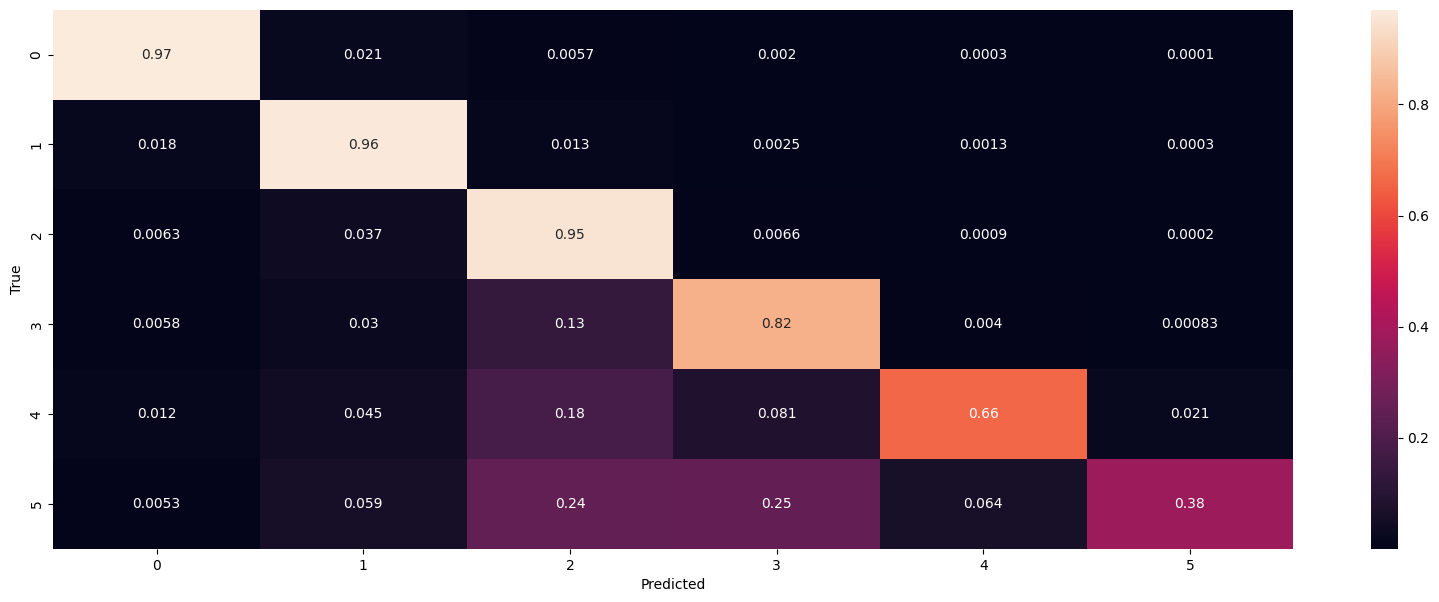

In [146]:
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")

In [147]:
print(classification_report(test_labels, predictions_comb))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      9960
           1       0.92      0.96      0.94     10064
           2       0.88      0.95      0.91     10008
           3       0.95      0.82      0.88      6042
           4       0.94      0.66      0.78      1535
           5       0.62      0.38      0.47       188

    accuracy                           0.92     37797
   macro avg       0.88      0.79      0.83     37797
weighted avg       0.93      0.92      0.92     37797



## Multi-Step Model

In [61]:
#del vdataset
del tdataset
del dataset

### Step 1

In [48]:
s1_train_labels = train_labels.copy()
s1_train_labels[(s1_train_labels == 5) | (s1_train_labels == 4)] = 3

s1_valid_labels = valid_labels.copy()
s1_valid_labels[(s1_valid_labels == 5) | (s1_valid_labels == 4)] = 3

s1_test_labels = test_labels.copy()
s1_test_labels[(s1_test_labels == 5) | (s1_test_labels == 4)] = 3

In [49]:
s1_roberta_model = create_roberta_cl_model(model=roberta_model, num_classes=4)

In [50]:
dataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": train_encodings.input_ids, "attention_mask_layer": train_encodings.attention_mask}, s1_train_labels))
dataset = dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

vdataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": valid_encodings.input_ids, "attention_mask_layer": valid_encodings.attention_mask}, s1_valid_labels))
vdataset = vdataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [51]:
s1_roberta_history = s1_roberta_model.fit(dataset,
                                      validation_data=vdataset,
                                      epochs=1)

9362/9362 [==============================] - 1168s 124ms/step - loss: 0.3031 - accuracy: 0.8897 - val_loss: 0.1552 - val_accuracy: 0.9449


In [52]:
tdataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": test_encodings.input_ids, "attention_mask_layer": test_encodings.attention_mask}, s1_test_labels))
tdataset = tdataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [53]:
s1_roberta_model.evaluate(tdataset)

1182/1182 [==============================] - 114s 97ms/step - loss: 0.1570 - accuracy: 0.9455


[0.15700982511043549, 0.9454983472824097]

In [72]:
predictions_s1 = s1_roberta_model.predict([test_encodings['input_ids'], test_encodings["attention_mask"]])
predictions_s1 = tf.argmax(predictions_s1, axis=-1)

1182/1182 [==============================] - 119s 98ms/step


### Step 2

In [67]:
train_mask = tf.equal(s1_train_labels, 3)
s2_train_encodings = {"input_ids": tf.boolean_mask(train_encodings['input_ids'], train_mask),
                     "attention_mask": tf.boolean_mask(train_encodings['attention_mask'], train_mask)}
s2_train_labels =  tf.boolean_mask(train_labels.copy(), train_mask) -3
s2_dataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": s2_train_encodings['input_ids'], "attention_mask_layer": s2_train_encodings['attention_mask']}, s2_train_labels))
s2_dataset = s2_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)


valid_mask = tf.equal(s1_valid_labels, 3)
s2_valid_encodings = {"input_ids": tf.boolean_mask(valid_encodings['input_ids'], valid_mask),
                     "attention_mask": tf.boolean_mask(valid_encodings['attention_mask'], valid_mask)}
s2_valid_labels = tf.boolean_mask(valid_labels.copy(), valid_mask) - 3
s2_vdataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": s2_valid_encodings['input_ids'], "attention_mask_layer": s2_valid_encodings['attention_mask']}, s2_valid_labels))
s2_vdataset = s2_vdataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

test_mask = tf.equal(s1_test_labels, 3)
s2_test_encodings = {"input_ids": tf.boolean_mask(test_encodings['input_ids'], test_mask),
                     "attention_mask": tf.boolean_mask(test_encodings['attention_mask'], test_mask)}
s2_test_labels = tf.boolean_mask(test_labels.copy(), test_mask) - 3
s2_tdataset = tf.data.Dataset.from_tensor_slices(({"input_ids_layer": s2_test_encodings['input_ids'], "attention_mask_layer": s2_test_encodings['attention_mask']}, s2_test_labels))
s2_tdataset = s2_tdataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)


In [68]:
s2_roberta_model = create_roberta_cl_model(model=roberta_model, num_classes=3)

In [69]:
s2_roberta_history = s2_roberta_model.fit(s2_dataset,
                                      validation_data=s2_vdataset,
                                      epochs=1)

1932/1932 [==============================] - 254s 125ms/step - loss: 0.3297 - accuracy: 0.8851 - val_loss: 0.2267 - val_accuracy: 0.9234


In [73]:
predictions_s2 = s2_roberta_model.predict([s2_test_encodings['input_ids'], s2_test_encodings["attention_mask"]])
predictions_s2 = tf.argmax(predictions_s2, axis=-1)

243/243 [==============================] - 27s 98ms/step


### Combine

In [86]:
pred_mask = tf.equal(predictions_s1, 3)
s2_test_encodings = {"input_ids": tf.boolean_mask(test_encodings['input_ids'], pred_mask),
                     "attention_mask": tf.boolean_mask(test_encodings['attention_mask'], pred_mask)}
predictions_s2_2 = s2_roberta_model.predict([s2_test_encodings['input_ids'], s2_test_encodings["attention_mask"]])
predictions_s2_2 = tf.argmax(predictions_s2_2, axis=-1)

predictions_s2_2 = predictions_s2_2.numpy() + 3

predictions_comb = predictions_s1.numpy()
predictions_comb[pred_mask] = predictions_s2_2

233/233 [==============================] - 23s 99ms/step


In [87]:
print(classification_report(test_labels, predictions_comb))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      9960
           1       0.95      0.95      0.95     10064
           2       0.93      0.94      0.93     10008
           3       0.90      0.89      0.89      6042
           4       0.81      0.72      0.76      1535
           5       0.73      0.29      0.42       188

    accuracy                           0.93     37797
   macro avg       0.88      0.80      0.82     37797
weighted avg       0.93      0.93      0.93     37797



In [88]:
cm = tf.math.confusion_matrix(test_labels, predictions_comb)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Text(220.72222222222223, 0.5, 'True')

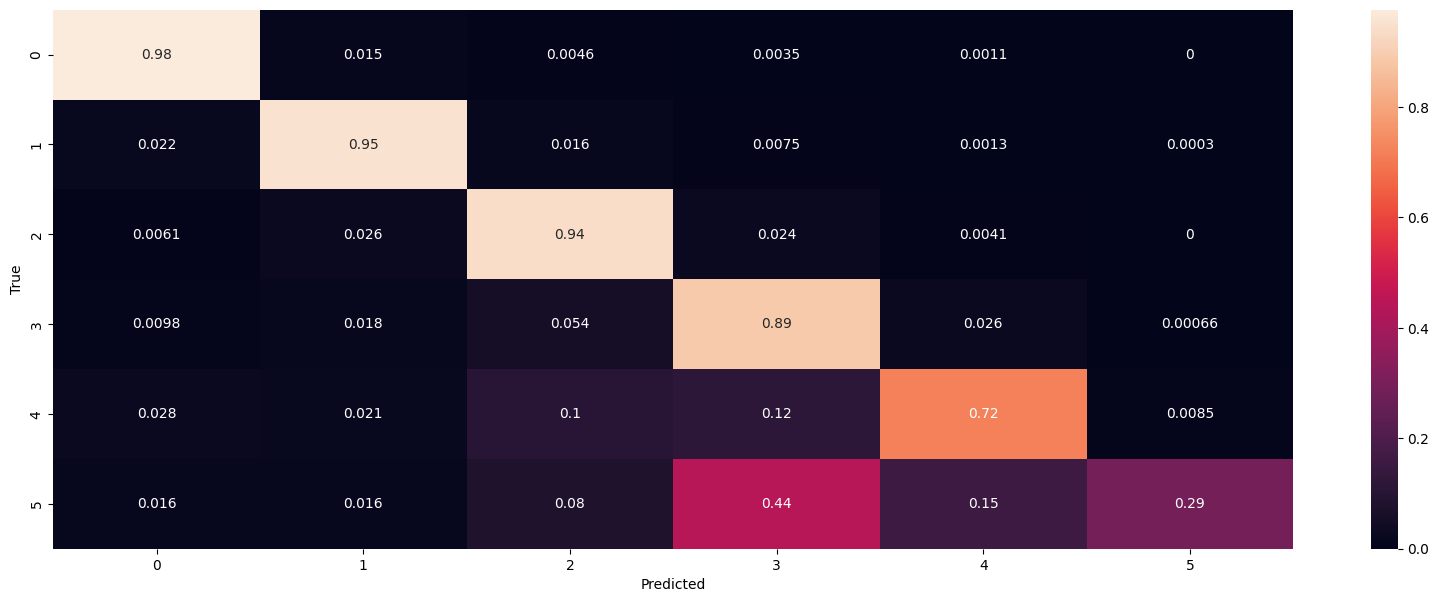

In [90]:
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")